In [1]:
import cv2
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 5

In [2]:
with open("../../images/calibration/images.dictionary", 'rb') as f:
    data = pkl.load(f)
data.keys()

['Trace', '300', '30', 'Negative', '2000', '100']

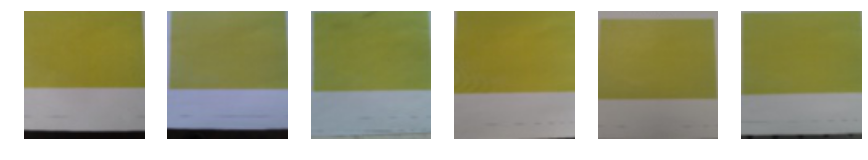

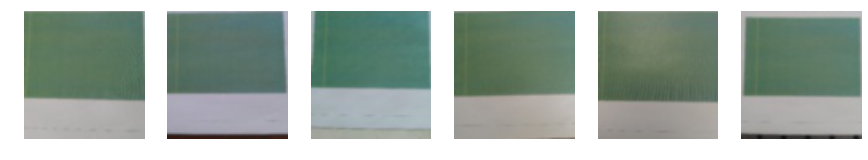

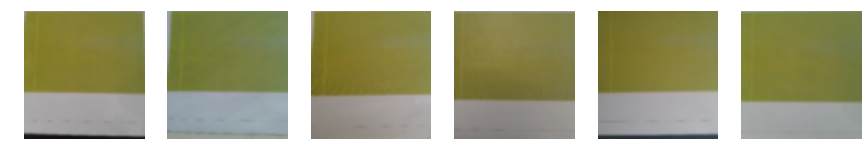

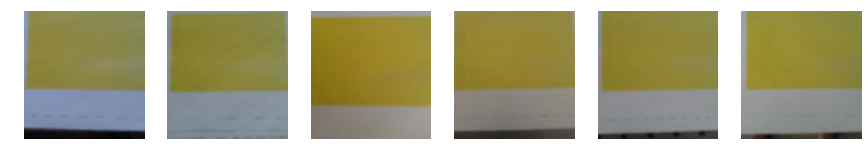

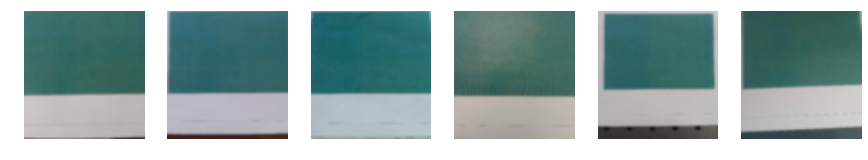

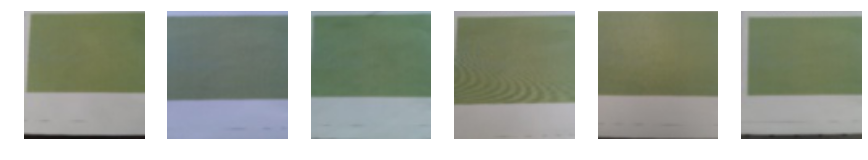

In [3]:
for key in data.keys():
    for j in range(len(data[key]))[:6]:
        plt.subplot(1, 6, j + 1)
        plt.axis('off')
        plt.imshow(data[key][j])
    plt.show()

In [227]:
from scipy.signal import convolve, gaussian

In [157]:
def get_color_hist(image, bins=24, marginx_percent=10, marginy_percent=10):
    """
    Calc and concat 3 hists (1 per channel) of the upper half.
    """
    marginy = (1. / marginy_percent) * image.shape[0]
    marginx = (1. / marginx_percent) * image.shape[1]
    halfy = image.shape[0] / 2
    crop = image[marginy: halfy - marginy, marginx: image.shape[1] - marginx, :]

    return np.concatenate([np.histogram(crop[:, :, j], bins=bins, normed=True)[0] for j in (0, 1, 2)])

/home/lysuhin/Distr/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


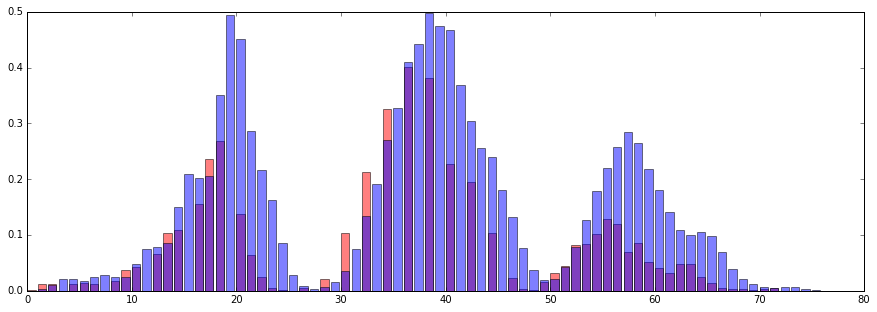

In [232]:
clrhst = get_color_hist(data.items()[0][1][0])
plt.bar(range(len(clrhst)), clrhst, color='red', alpha=0.5)
kernel = gaussian(5, 1)
clrhst_c = convolve(clrhst, kernel)
plt.bar(range(len(clrhst_c)), clrhst_c, color='blue', alpha=0.5)
plt.show()

In [159]:
def get_white_hist(image, bins=24, top_white=15):
    """
    Calc and concat 3 hists (1 per channel) of the top_white % pixels.
    """
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    top_white_L = np.percentile(image_gray.ravel(), q=100-top_white)
    idxs = np.where(image_gray >= top_white_L)
    
    return np.concatenate([np.histogram(image[idxs[0], idxs[1], j], bins=bins, normed=True)[0] for j in (0, 1, 2)])

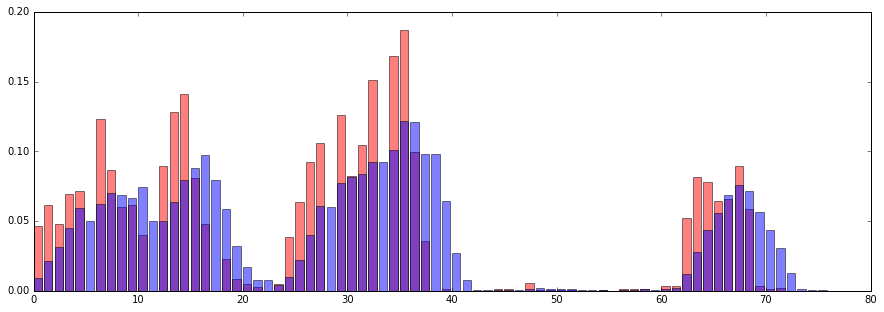

In [233]:
whthst = get_white_hist(data.items()[0][1][0])
plt.bar(range(len(whthst)), whthst, color='red', alpha=0.5)
kernel = gaussian(5, 1)
hthst_c = convolve(whthst, kernel)
plt.bar(range(len(whthst_c)), whthst_c, color='blue', alpha=0.5)
plt.show()

In [234]:
def get_hists(image):
    return np.concatenate((get_color_hist(image), get_white_hist(image)))

def convolver(hist, window=7):
    kernel = gaussian(5, 1)
#     return convolve(hist, [1. / window] * window)
    return convolve(hist, kernel)


def int_label(string):
    d = {'Negative': 0, 
         'Trace': 1,
         '30': 30,
         '100': 100,
         '300': 500,
         '2000': 2000}
    return d[string]

In [235]:
def make_data_with_histograms(data):
    X, y = [], []
    for key in data.keys():
        for image in data[key]:
            X.append(convolver(get_hists(image)))
            y.append(int_label(key))
    return np.array(X), np.array(y)

In [236]:
X, y = make_data_with_histograms(data)
X.shape, y.shape

/home/lysuhin/Distr/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


((147, 148), (147,))

In [237]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [239]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [248]:
lr = LogisticRegression(n_jobs=4, C=1e-2)
lr.fit(X_train, y_train)
print(accuracy_score(y_train, lr.predict(X_train)))
print(accuracy_score(y_test, lr.predict(X_test)))

0.790909090909
0.513513513514


In [244]:
svm = SVC(kernel='linear', C=1e-1)
svm.fit(X_train, y_train)
print(accuracy_score(y_train, svm.predict(X_train)))
print(accuracy_score(y_test, svm.predict(X_test)))

0.963636363636
0.567567567568
